![](http://www.dataivy.cn/book/images/head.png)
<table align="center" bgcolor="#FFFFFF" border="0px">
   <tr bgcolor="#FFFFFF">
      <td><img src="http://www.dataivy.cn/book/images/release_date.svg"></td>
      <td><img src="http://www.dataivy.cn/book/images/python-3.7-green.svg"></td>
      <td><a href="http://www.dataivy.cn/blog/python_book_faq/"><img src="http://www.dataivy.cn/book/images/faq-visit_site-blue.svg"></a></td>
      <td><a href="http://www.dataivy.cn/blog/python_book_knows_issues/"><img src="http://www.dataivy.cn/book/images/known_issues.svg"></a></td>
   </tr>
</table>


<hr />

<div align="center"><h1> 第四章&nbsp;&nbsp;跳过运营数据分析和挖掘的“大坑”</h1></div>

# 一、说明

- 描述：“代码实操”以及内容延伸部分源代码
- 时间：2019-01-01
- 作者：宋天龙（Tony Song）
- 程序开发环境：win7 64位
- Python版本：64位 3.7
- 依赖库：具体查看各模块
- 程序输入：具体查看各模块
- 程序输出：具体查看各模块

# 二、程序

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## 4.1 聚类分析-案例：客户特征的聚类与探索性分析

In [2]:
# 导入库
import pandas as pd # panda库
import numpy as np
import matplotlib.pyplot as plt  # 导入matplotlib库
from sklearn.preprocessing import MinMaxScaler # 标准化库
from sklearn.cluster import KMeans  # 导入sklearn聚类模块
from sklearn.metrics import silhouette_score, calinski_harabaz_score  # 效果评估模块
import matplotlib.pyplot as plt # 图形库

In [3]:
# 读取数据
raw_data = pd.read_csv('cluster.txt')  # 导入数据文件
numeric_features = raw_data.iloc[:,1:3] # 数值型特征

In [4]:
# 数据标准化
scaler = MinMaxScaler()
scaled_numeric_features = scaler.fit_transform(numeric_features)
print(scaled_numeric_features[:,:2])

[[0.64200477 0.62591687]
 [0.91169451 0.80440098]
 [0.69451074 0.39608802]
 ...
 [0.3221957  0.17359413]
 [0.42004773 0.31295844]
 [0.64916468 0.40831296]]


In [5]:
# 训练聚类模型
n_clusters = 3  # 设置聚类数量
model_kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # 建立聚类模型对象
model_kmeans.fit(scaled_numeric_features)  # 训练聚类模型

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

> 读者可执行下面的pipe程序段

In [6]:
'''
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

pipeline = PMMLPipeline([("kmeans", KMeans(n_clusters=n_clusters, random_state=0))])
pipeline.fit(scaled_numeric_features)

sklearn2pmml(pipeline, "kmeans.pmml", with_repr = True)
'''

'\nfrom sklearn2pmml.pipeline import PMMLPipeline\nfrom sklearn2pmml import sklearn2pmml\n\npipeline = PMMLPipeline([("kmeans", KMeans(n_clusters=n_clusters, random_state=0))])\npipeline.fit(scaled_numeric_features)\n\nsklearn2pmml(pipeline, "kmeans.pmml", with_repr = True)\n'

In [7]:
# 模型效果指标评估
# 总样本量,总特征数
n_samples, n_features = raw_data.iloc[:,1:].shape
print('samples: %d \t features: %d' % (n_samples, n_features))

# 非监督式评估方法
silhouette_s = silhouette_score(scaled_numeric_features, model_kmeans.labels_, metric='euclidean')  # 平均轮廓系数
calinski_harabaz_s = calinski_harabaz_score(scaled_numeric_features, model_kmeans.labels_)  # Calinski和Harabaz得分
unsupervised_data = {'silh':[silhouette_s],'c&h':[calinski_harabaz_s]}
unsupervised_score = pd.DataFrame.from_dict(unsupervised_data)
print('\n','unsupervised score:','\n','-'*60)
print(unsupervised_score)

samples: 1000 	 features: 4

 unsupervised score: 
 ------------------------------------------------------------
       silh          c&h
0  0.634086  2860.821834


In [8]:
# 合并数据和特征
# 获得每个样本的聚类类别
kmeans_labels = pd.DataFrame(model_kmeans.labels_,columns=['labels']) 
# 组合原始数据与标签
kmeans_data = pd.concat((raw_data,kmeans_labels),axis=1)
print(kmeans_data.head())

   USER_ID  AVG_ORDERS  AVG_MONEY IS_ACTIVE  SEX  labels
0        1        3.58      40.43        活跃    1       2
1        2        4.71      41.16       不活跃    1       2
2        3        3.80      39.49       不活跃    2       1
3        4        2.85      38.36       不活跃    1       0
4        5        3.71      38.34        活跃    1       1


In [9]:
# 计算不同聚类类别的样本量和占比
label_count = kmeans_data.groupby(['labels'])['SEX'].count()  # 计算频数
label_count_rate = label_count/ kmeans_data.shape[0] # 计算占比
kmeans_record_count = pd.concat((label_count,label_count_rate),axis=1)
kmeans_record_count.columns=['record_count','record_rate']
print(kmeans_record_count.head())

        record_count  record_rate
labels                           
0                332        0.332
1                337        0.337
2                331        0.331


In [10]:
# 计算不同聚类类别数值型特征
kmeans_numeric_features = kmeans_data.groupby(['labels'])['AVG_ORDERS','AVG_MONEY'].mean()
print(kmeans_numeric_features.head())

        AVG_ORDERS  AVG_MONEY
labels                       
0         2.022349  38.980602
1         3.987389  39.028754
2         3.958610  40.996254


In [11]:
# 计算不同聚类类别分类型特征
active_list = []
sex_gb_list = []
unique_labels = np.unique(model_kmeans.labels_)
for each_label in unique_labels:
    each_data = kmeans_data[kmeans_data['labels']==each_label]
    active_list.append(each_data.groupby(['IS_ACTIVE'])['USER_ID'].count()/each_data.shape[0])
    sex_gb_list.append(each_data.groupby(['SEX'])['USER_ID'].count()/each_data.shape[0])

kmeans_active_pd = pd.DataFrame(active_list)
kmeans_sex_gb_pd = pd.DataFrame(sex_gb_list)
kmeans_string_features = pd.concat((kmeans_active_pd,kmeans_sex_gb_pd),axis=1)
kmeans_string_features.index = unique_labels
print(kmeans_string_features.head())

        不活跃        活跃         0         1         2
0  0.487952  0.512048  0.003012  0.990964  0.006024
1  0.495549  0.504451  0.014837  0.014837  0.970326
2  0.504532  0.495468  0.984894  0.009063  0.006042


In [12]:
# 合并所有类别的分析结果
features_all = pd.concat((kmeans_record_count,kmeans_numeric_features,kmeans_string_features),axis=1)
print(features_all.head())

        record_count  record_rate  AVG_ORDERS  AVG_MONEY       不活跃        活跃  \
labels                                                                         
0                332        0.332    2.022349  38.980602  0.487952  0.512048   
1                337        0.337    3.987389  39.028754  0.495549  0.504451   
2                331        0.331    3.958610  40.996254  0.504532  0.495468   

               0         1         2  
labels                                
0       0.003012  0.990964  0.006024  
1       0.014837  0.014837  0.970326  
2       0.984894  0.009063  0.006042  


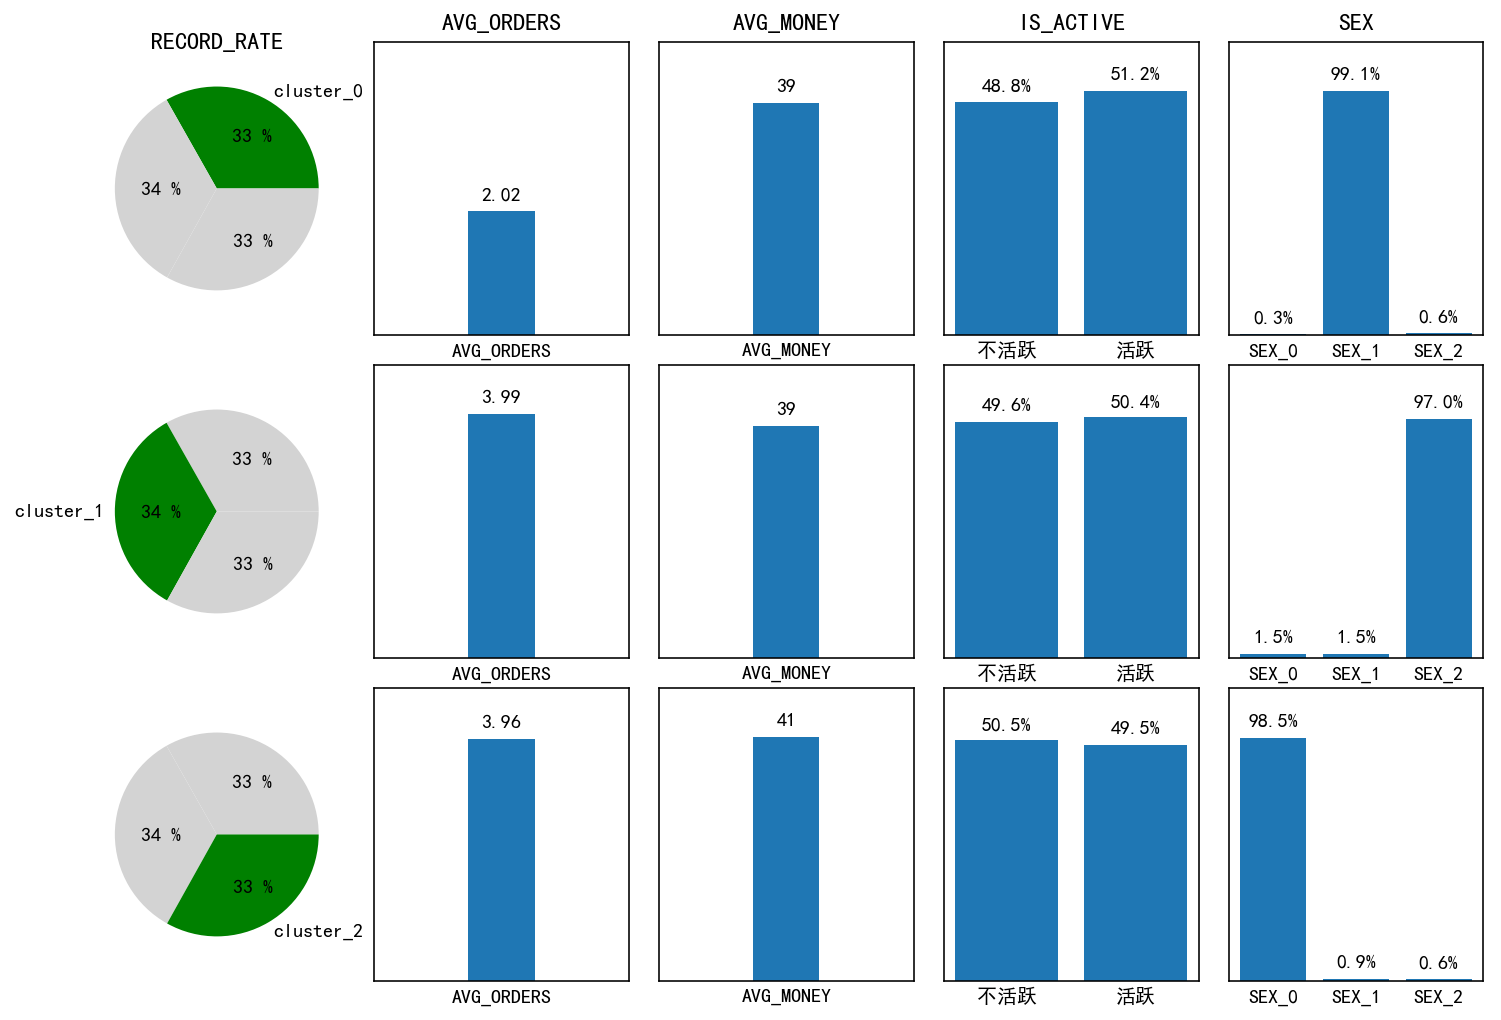

In [13]:
# 可视化图形展示
# part 1 全局配置
fig = plt.figure(figsize=(10, 7))
titles = ['RECORD_RATE','AVG_ORDERS','AVG_MONEY','IS_ACTIVE','SEX'] # 共用标题
line_index,col_index = 3,5 # 定义网格数
ax_ids = np.arange(1,16).reshape(line_index,col_index) # 生成子网格索引值
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    
# part 2 画出三个类别的占比
pie_fracs = features_all['record_rate'].tolist()
for ind in range(len(pie_fracs)):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,0][ind])
    init_labels = ['','',''] # 初始化空label标签
    init_labels[ind] = 'cluster_{0}'.format(ind) # 设置标签
    init_colors = ['lightgray', 'lightgray', 'lightgray']
    init_colors[ind] = 'g' # 设置目标面积区别颜色
    ax.pie(x=pie_fracs, autopct='%3.0f %%',labels=init_labels,colors=init_colors)
    ax.set_aspect('equal') # 设置饼图为圆形
    if ind == 0:
        ax.set_title(titles[0])
    
# part 3  画出AVG_ORDERS均值
avg_orders_label = 'AVG_ORDERS'
avg_orders_fraces = features_all[avg_orders_label]
for ind, frace in enumerate(avg_orders_fraces):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,1][ind])
    ax.bar(x=unique_labels,height=[0,avg_orders_fraces[ind],0])# 画出柱形图
    ax.set_ylim((0, max(avg_orders_fraces)*1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    if ind == 0:# 设置总标题
        ax.set_title(titles[1])
    # 设置每个柱形图的数值标签和x轴label
    ax.text(unique_labels[1],frace+0.4,s='{:.2f}'.format(frace),ha='center',va='top')
    ax.text(unique_labels[1],-0.4,s=avg_orders_label,ha='center',va='bottom')
        
# part 4  画出AVG_MONEY均值
avg_money_label = 'AVG_MONEY'
avg_money_fraces = features_all[avg_money_label]
for ind, frace in enumerate(avg_money_fraces):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,2][ind])
    ax.bar(x=unique_labels,height=[0,avg_money_fraces[ind],0])# 画出柱形图
    ax.set_ylim((0, max(avg_money_fraces)*1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    if ind == 0:# 设置总标题
        ax.set_title(titles[2])
    # 设置每个柱形图的数值标签和x轴label
    ax.text(unique_labels[1],frace+4,s='{:.0f}'.format(frace),ha='center',va='top')
    ax.text(unique_labels[1],-4,s=avg_money_label,ha='center',va='bottom')
        
# part 5  画出是否活跃
axtivity_labels = ['不活跃','活跃']
x_ticket = [i for i in range(len(axtivity_labels))]
activity_data = features_all[axtivity_labels]
ylim_max = np.max(np.max(activity_data))
for ind,each_data in enumerate(activity_data.values):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,3][ind])
    ax.bar(x=x_ticket,height=each_data) # 画出柱形图
    ax.set_ylim((0, ylim_max*1.2))
    ax.set_xticks([])
    ax.set_yticks([])    
    if ind == 0:# 设置总标题
        ax.set_title(titles[3])
    # 设置每个柱形图的数值标签和x轴label
    activity_values = ['{:.1%}'.format(i) for i in each_data]
    for i in range(len(x_ticket)):
        ax.text(x_ticket[i],each_data[i]+0.05,s=activity_values[i],ha='center',va='top')
        ax.text(x_ticket[i],-0.05,s=axtivity_labels[i],ha='center',va='bottom')
        
# part 6  画出性别分布
sex_data = features_all.iloc[:,-3:]
x_ticket = [i for i in range(len(sex_data))]
sex_labels = ['SEX_{}'.format(i) for i in range(3)]
ylim_max = np.max(np.max(sex_data))
for ind,each_data in enumerate(sex_data.values):
    ax = fig.add_subplot(line_index, col_index, ax_ids[:,4][ind])
    ax.bar(x=x_ticket,height=each_data) # 画柱形图
    ax.set_ylim((0, ylim_max*1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    if ind == 0: # 设置标题
       ax.set_title(titles[4])    
    # 设置每个柱形图的数值标签和x轴label
    sex_values = ['{:.1%}'.format(i) for i in each_data]
    for i in range(len(x_ticket)):
        ax.text(x_ticket[i],each_data[i]+0.1,s=sex_values[i],ha='center',va='top')
        ax.text(x_ticket[i],-0.1,s=sex_labels[i],ha='center',va='bottom')
    
plt.tight_layout(pad=0.8) #设置默认的间距

## 4.2 回归分析-案例：大型促销活动前的销售预测

In [14]:
# 导入库
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge, ElasticNet# 批量导入要实现的回归算法
from sklearn.svm import SVR  # SVM中的回归算法
from xgboost import XGBRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor  # 集成算法
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
mean_squared_error, r2_score  # 批量导入指标算法
import matplotlib.pyplot as plt  # 导入图形展示库

In [15]:
# 数据准备
raw_data = np.loadtxt('regression.txt')  # 读取数据文件
X_raw,y = raw_data[:, :-1],raw_data[:, -1]  # 分割自变量,因变量
model_ss = StandardScaler()
X = model_ss.fit_transform(X_raw)

In [16]:
# 拆分数据集
num = int(X.shape[0]*0.7)
X_train,X_test = X[:num,:],X[num:,:] # 拆分训练集和测试集
y_train,y_test = y[:num],y[num:] # 拆分训练集和测试集

In [17]:
# 初选回归模型
n_folds = 5  # 设置交叉检验的次数
model_names = ['BayesianRidge', 'XGBR', 'ElasticNet', 'SVR', 'GBR']  # 不同模型的名称列表
model_br = BayesianRidge()  # 建立贝叶斯岭回归模型对象
model_xgbr = XGBRegressor(random_state=0)  # 建立XGBR对象
model_etc = ElasticNet(random_state=0)  # 建立弹性网络回归模型对象
model_svr = SVR(gamma='scale')  # 建立支持向量机回归模型对象
model_gbr = GradientBoostingRegressor(random_state=0)  # 建立梯度增强回归模型对象
model_list = [model_br, model_xgbr, model_etc,model_svr, model_gbr]  # 不同回归模型对象的集合
pre_y_list = [model.fit(X_train, y_train).predict(X_test) for model in model_list]  # 各个回归模型预测的y值列表

In [18]:
# 模型效果评估
n_samples, n_features = X.shape  # 总样本量,总特征数
model_metrics_functions = [explained_variance_score, mean_absolute_error, mean_squared_error,r2_score]  # 回归评估指标对象集
model_metrics_list = [[m(y_test, pre_y_list[i]) for m in model_metrics_functions] for i in range(len(model_list))]  # 回归评估指标列表
regresstion_score = pd.DataFrame(model_metrics_list, index=model_names,
                   columns=['explained_variance', 'mae', 'mse', 'r2'])  # 建立回归指标的数据框
print('all samples: %d \t features: %d' % (n_samples, n_features),'\n','-'*60)  # 打印输出样本量和特征数量
print('\n','regression metrics:','\n','-'*60)  # 打印输出标题
print(regresstion_score)  # 打印输出回归指标的数据框

all samples: 506 	 features: 13 
 ------------------------------------------------------------

 regression metrics: 
 ------------------------------------------------------------
               explained_variance       mae         mse        r2
BayesianRidge           -0.687351  7.659164  121.318236 -0.828561
XGBR                     0.266921  4.646828   50.015036  0.246152
ElasticNet               0.071882  6.291600   70.266387 -0.059086
SVR                      0.008871  8.072168  100.546554 -0.515482
GBR                      0.230913  4.922672   53.285483  0.196858


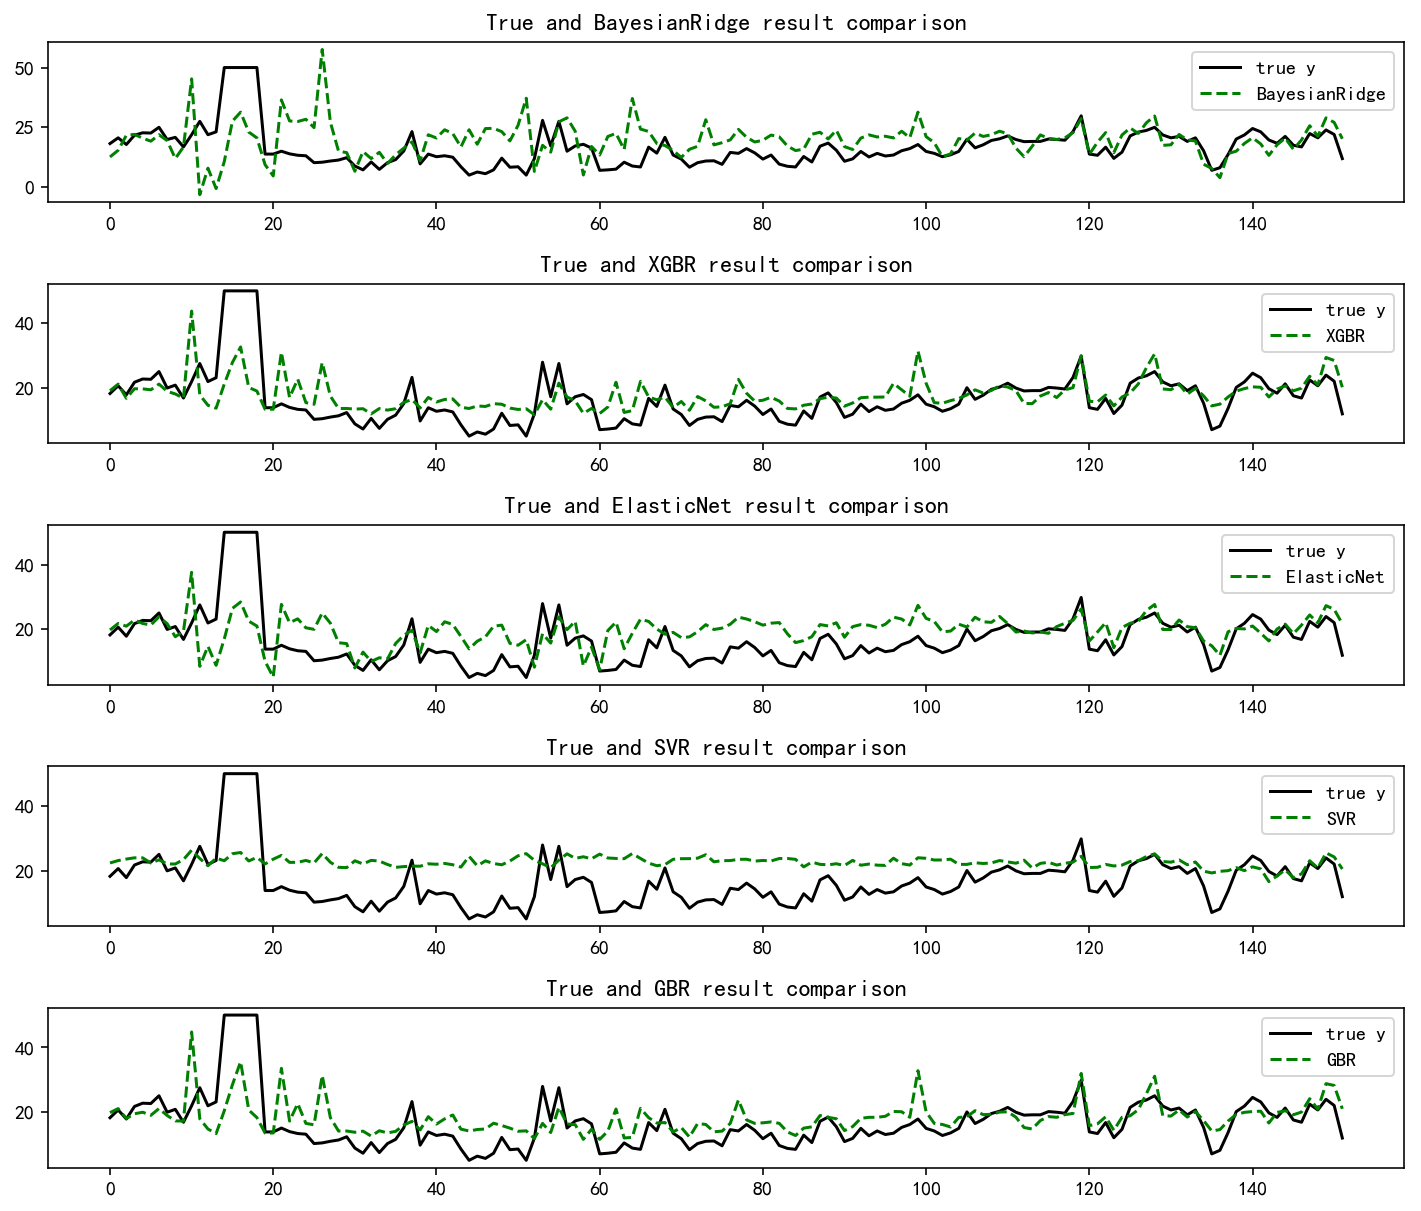

In [19]:
# 模型效果可视化
plt.figure(figsize=(10, 10))  # 创建画布
for i, pre_y in enumerate(pre_y_list):  # 读出通过回归模型预测得到的索引及结果
    plt.subplot(len(pre_y_list)+1,1,i+1)
    plt.plot(np.arange(len(y_test)), y_test, color='k', label='true y')  # 画出原始值的曲线
    plt.plot(np.arange(len(y_test)), pre_y_list[i], 'g--', label=model_names[i])  # 画出每条预测结果线
    plt.title('True and {} result comparison'.format(model_names[i]))  # 标题
    plt.legend(loc='upper right')  # 图例位置
    plt.tight_layout() # 自动调整子图间隔

In [20]:
# 模型应用
print('regression prediction','\n','-'*40)
new_point_set = [[1.05393, 0., 8.14, 0., 0.538, 5.935, 29.3, 4.4986, 4., 307., 21., 386.85, 6.58],
                 [0.7842, 0., 8.14, 0., 0.538, 5.99, 81.7, 4.2579, 4., 307., 21., 386.75, 14.67],
                 [0.80271, 0., 8.14, 0., 0.538, 5.456, 36.6, 3.7965, 4., 307., 21., 288.99, 11.69],
                 [0.7258, 0., 8.14, 0., 0.538, 5.727, 69.5, 3.7965, 4., 307., 21., 390.95,
                  11.28]]  # 要预测的新数据集
for i, new_point in enumerate(new_point_set):  # 循环读出每个要预测的数据点
    x_matrix = np.array(new_point).reshape(1, -1)
    x_scaled = model_ss.transform(x_matrix)
    new_pre_y = model_xgbr.predict(x_scaled)  # 使用GBR进行预测
    print('predict for new point %d is:  %.2f' % (i + 1, new_pre_y))  # 打印输出每个数据点的预测信息

regression prediction 
 ----------------------------------------
predict for new point 1 is:  22.28
predict for new point 2 is:  17.25
predict for new point 3 is:  18.82
predict for new point 4 is:  18.12


## 4.3 分类分析-案例：用户流失预测分析与应用

In [21]:
# 导入库
import pandas as pd
from sklearn.model_selection import train_test_split  # 数据分区库
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve  # 导入指标库
from imblearn.over_sampling import SMOTE  # 过抽样处理库SMOTE
import matplotlib.pyplot as plt
import prettytable  # 导入表格库

In [22]:
# 读取准备
raw_data = pd.read_csv('classification.csv', delimiter=',')  # 读取数据文件
X,y = raw_data.iloc[:, :-1],raw_data.iloc[:, -1]  # 分割X,y

In [23]:
# 数据基本审查
n_samples, n_features = X.shape  # 总样本量,总特征数
print('samples: {0}| features: {1} | na count: {2}'.format(n_samples, n_features,raw_data.isnull().any().count()))

samples: 1000| features: 41 | na count: 42


In [24]:
# 数据预处理
# 填充缺失值
X = X.fillna(X.mean())
# 样本均衡处理
#'''
model_smote = SMOTE()  # 建立SMOTE模型对象
X, y = model_smote.fit_sample(X,y)  # 输入数据并作过抽样处理
#'''

> 读者可以把上面样本均衡的过程注释掉看下样本均衡对结果的巨大影响！

In [25]:
# 拆分数据集
X = pd.DataFrame(X,columns=raw_data.columns[:-1])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=0)  # 将数据分为训练集和测试集

In [26]:
# XGB分类模型训练
param_dist = {'objective': 'binary:logistic', 'n_estimators': 10,
              'subsample': 0.8, 'max_depth': 10, 'n_jobs': -1}
model_xgb = xgb.XGBClassifier(**param_dist)
model_xgb.fit(X_train, y_train)
pre_y = model_xgb.predict(X_test)

In [27]:
# 混淆矩阵
tn, fp, fn, tp = confusion_matrix(y_test, pre_y).ravel()  # 获得混淆矩阵
confusion_matrix_table = prettytable.PrettyTable(['','prediction-0','prediction-1'])  # 创建表格实例
confusion_matrix_table.add_row(['actual-0',tp,fn])  # 增加第一行数据
confusion_matrix_table.add_row(['actual-1',fp,tn])  # 增加第二行数据
print('confusion matrix \n',confusion_matrix_table)

confusion matrix 
 +----------+--------------+--------------+
|          | prediction-0 | prediction-1 |
+----------+--------------+--------------+
| actual-0 |     189      |      25      |
| actual-1 |      46      |     176      |
+----------+--------------+--------------+


In [28]:
# 核心评估指标
y_score = model_xgb.predict_proba(X_test)  # 获得决策树的预测概率
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])  # ROC
auc_s = auc(fpr, tpr)  # AUC
scores = [round(i(y_test, pre_y),3 )for  i in (accuracy_score,precision_score,\
                                     recall_score,f1_score)]
scores.insert(0,auc_s)
core_metrics = prettytable.PrettyTable()  # 创建表格实例
core_metrics.field_names = ['auc', 'accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row(scores)  # 增加数据
print('core metrics\n',core_metrics)

core metrics
 +--------------------+----------+-----------+--------+-------+
|        auc         | accuracy | precision | recall |   f1  |
+--------------------+----------+-----------+--------+-------+
| 0.9023111896943673 |  0.837   |   0.804   | 0.883  | 0.842 |
+--------------------+----------+-----------+--------+-------+


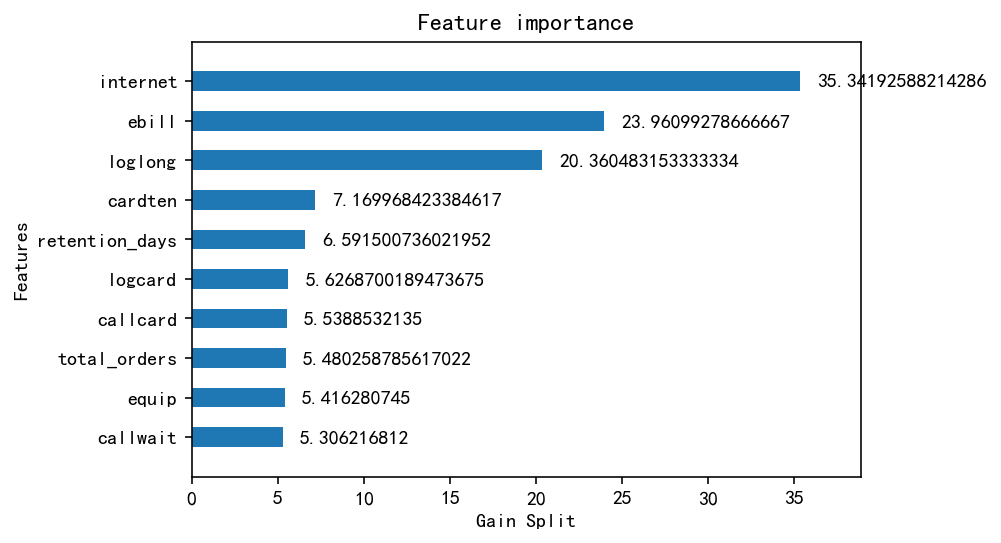

In [29]:
# 输出特征重要性
xgb.plot_importance(model_xgb,height=0.5,importance_type='gain',max_num_features=10,xlabel='Gain Split',grid=False) 

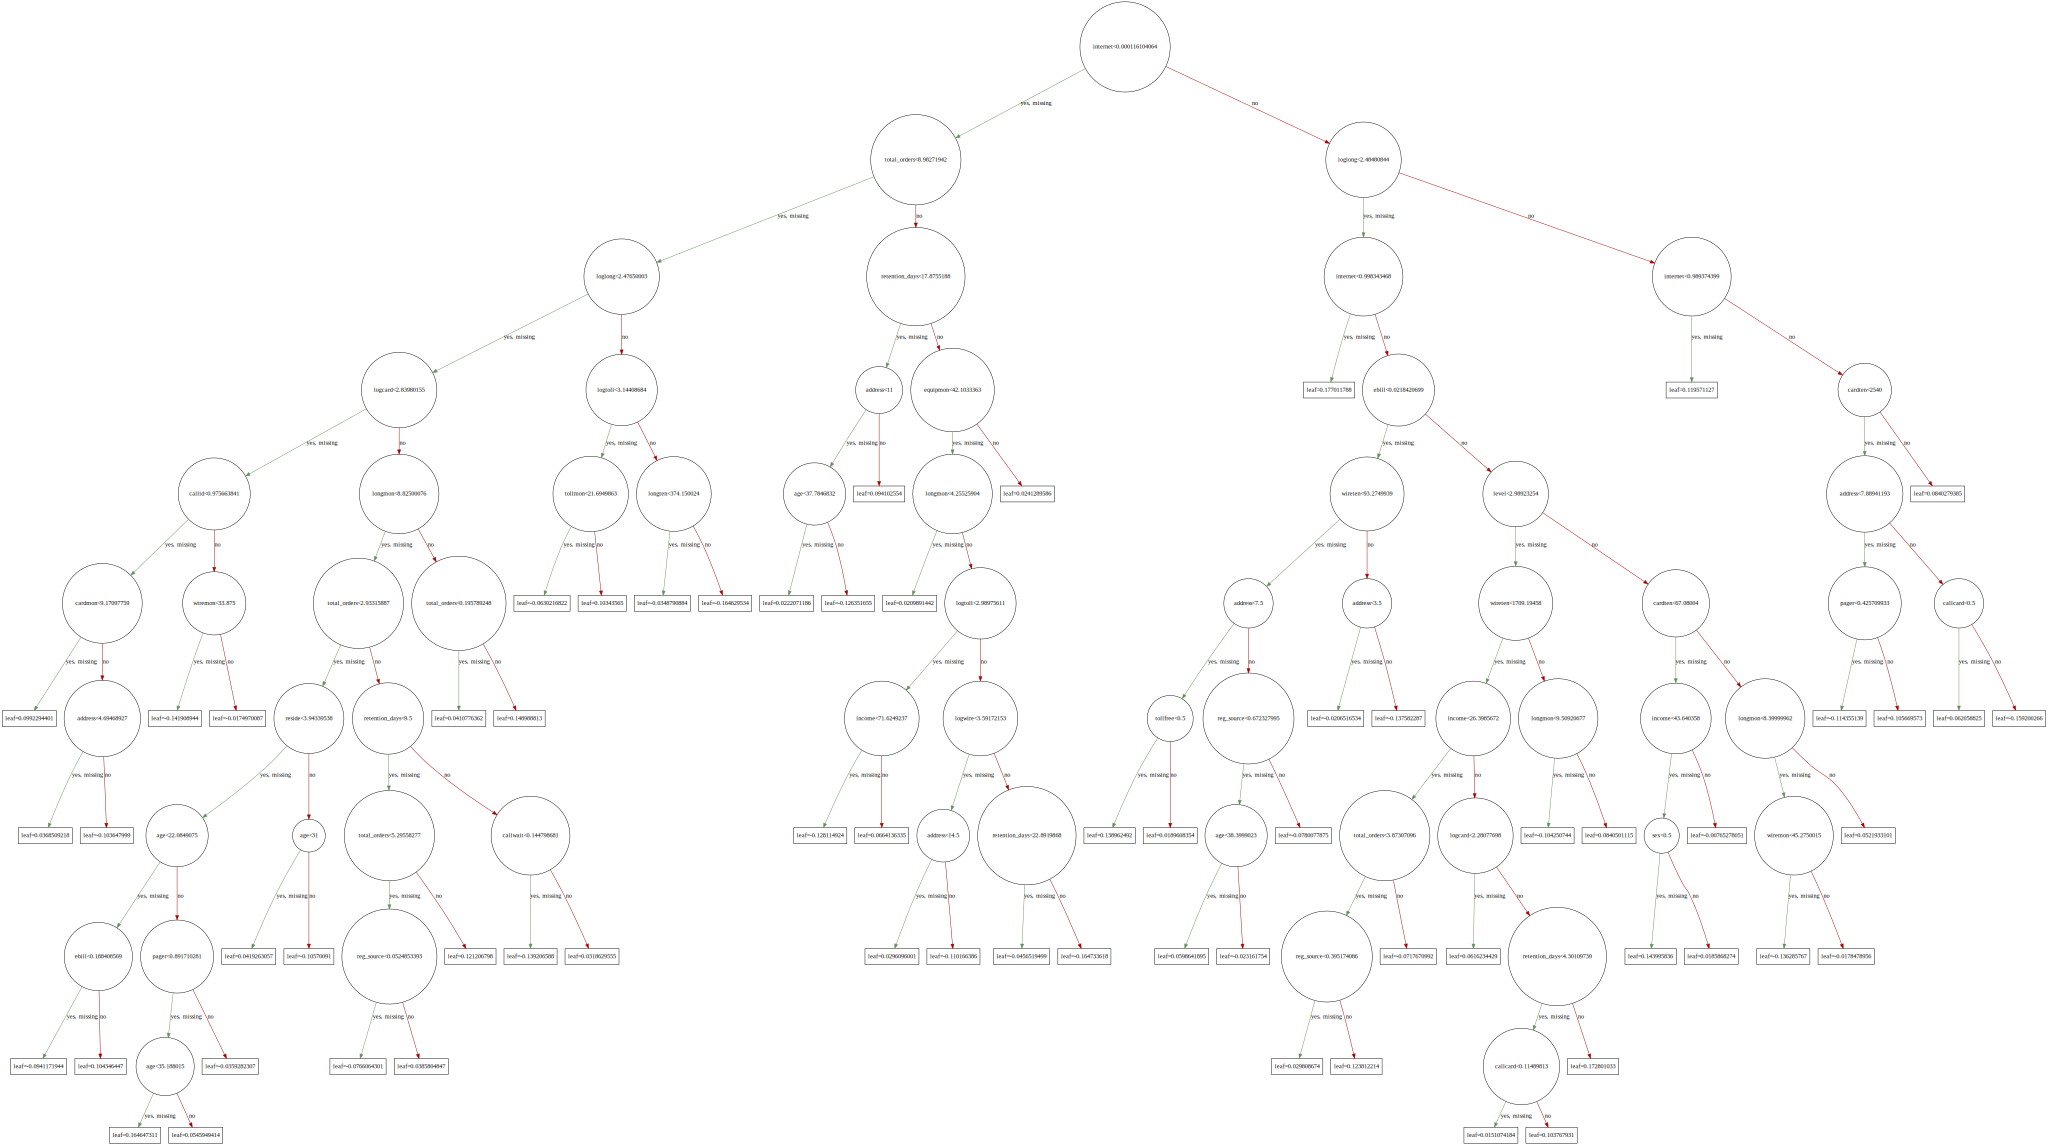

In [30]:
# 输出树形规则图
xgb.to_graphviz(model_xgb, num_trees=1, yes_color='#638e5e', no_color='#a40000') 

In [31]:
# 前N条规则对应的用户数据
rule_depth_1 = X_test['internet']<0.00284512946
rule_depth_2 = X_test['longten']<230.75
rule_depth_3 = X_test['total_orders']<2.97253799
rule_depth_4 = X_test['sex']<0.972537994
rule_depth_5 = X_test['wireten']<86.0607376
rule_list = [rule_depth_1,rule_depth_2,rule_depth_3,rule_depth_4,rule_depth_5]
rule_pd = [pd.DataFrame(i) for i in rule_list]
rule_pd_merge = pd.concat(rule_pd,axis=1)

# 遍历不同条件下用户的情况
for i in range(5):
    dyn_rules = rule_pd_merge.iloc[:,:i+1] # 取出top规则
    dyn_rules['is_true']=[all(i)==True for i in dyn_rules.values]# 得到都为true的record
    y_test_selected = y_test[dyn_rules['is_true']]
    y_pre_selected = y_score[dyn_rules['is_true']]
    y_pre_cal = y_pre_selected[:,1] >=0.5
    total_samples = len(y_pre_cal)
    is_churn = y_pre_cal.sum()
    churn_rate = float(is_churn)/total_samples
    # 计算样本比例
    print('total samples: {}'.format(total_samples))
    print('churn samples: {} | rate: {:.0%} '.format(is_churn,churn_rate))
    print('unchurn samples: {} | rate: {:.0%} '.format((total_samples-is_churn),(1-churn_rate)))
    print('-'*40)


total samples: 211
churn samples: 62 | rate: 29% 
unchurn samples: 149 | rate: 71% 
----------------------------------------
total samples: 91
churn samples: 48 | rate: 53% 
unchurn samples: 43 | rate: 47% 
----------------------------------------
total samples: 31
churn samples: 22 | rate: 71% 
unchurn samples: 9 | rate: 29% 
----------------------------------------
total samples: 18
churn samples: 14 | rate: 78% 
unchurn samples: 4 | rate: 22% 
----------------------------------------
total samples: 15
churn samples: 11 | rate: 73% 
unchurn samples: 4 | rate: 27% 
----------------------------------------


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
rule_pd_merge.head()

,internet,longten,total_orders,sex,wireten
1370,False,False,False,False,False
482,False,True,False,False,True
1292,False,False,True,False,False
270,True,False,True,False,True
278,True,False,False,True,True


## 4.4 关联分析

### Python完成关联分析

In [33]:
# 导入库
import pandas as pd
import apriori

In [34]:
# 定义数据文件
data = pd.read_csv('order_table.csv')

In [35]:
# 转换为关联所用的记录模式
order_ids = pd.unique(data['order_id'])
order_records = [data[data['order_id']==each_id]['product_name'].tolist() for each_id in order_ids]

In [36]:
# 通过调用自定义的apriori做关联分析
minS = 0.01  # 定义最小支持度阀值
minC = 0.05  # 定义最小置信度阀值
L, suppData = apriori.apriori(order_records, minSupport=minS)  # 计算得到满足最小支持度的规则
rules = apriori.generateRules(order_records, L, suppData, minConf=minC)  # 计算满足最小置信度的规则

In [37]:
# 关联结果报表评估
model_summary = 'data record: {1} \nassociation rules count: {0}'  # 展示数据集记录数和满足阀值定义的规则数量
print(model_summary.format(len(rules), len(order_records)),'\n','-'*60)  # 使用str.format做格式化输出
rules_all = pd.DataFrame(rules, columns=['item1', 'item2', 'instance', 'support', 'confidence',
                                  'lift'])  # 创建频繁规则数据框
rules_sort = rules_all.sort_values(['lift'],ascending=False)
rules_sort.head(10)

data record: 2240 
association rules count: 582 
 ------------------------------------------------------------


,item1,item2,instance,support,confidence,lift
346,(whipped/sour cream),(berries),27,0.0121,0.1525,4.1168
347,(berries),(whipped/sour cream),27,0.0121,0.3253,4.1168
492,(pip fruit),"(other vegetables, tropical fruit)",23,0.0103,0.1474,4.0772
493,(tropical fruit),"(other vegetables, pip fruit)",23,0.0103,0.1000,3.9298
517,(yogurt),"(other vegetables, fruit/vegetable juice)",26,0.0116,0.0836,3.6719
578,(curd),"(yogurt, whole milk)",29,0.0129,0.2042,3.6307
549,(root vegetables),"(yogurt, tropical fruit)",24,0.0107,0.0980,3.5972
550,(yogurt),"(root vegetables, tropical fruit)",24,0.0107,0.0772,3.5278
516,(fruit/vegetable juice),"(other vegetables, yogurt)",26,0.0116,0.1566,3.3735
548,(tropical fruit),"(yogurt, root vegetables)",24,0.0107,0.1043,3.2464


### Python调用R完成关联分析

In [38]:
# 导入库
from rpy2.robjects import r

> 如果在导入过程中提示“R_USER not defined.”或者“R_HOME Error with rpy2”，那么可以下方式解决：
> 1. 确保R已经安装，自行下载安装包即可
> 2. 在系统环境变量的PATH中，加入R的执行路径，笔者的路径为C:\Program Files\R\R-3.5.1\bin\x64
> 3. 在系统环境变量中，新增两个变量（这两个变量与PATH平级），分别是R_HOME和R_USER。具体信息为：

| 变量名 | 变量值 |
| ------ | ------ |
| R_HOME | C:\Program Files\R\R-3.5.1 | 
| R_USER | C:\Users\Administrator\Anaconda\Lib\site-packages\rpy2 |

In [39]:
# 定义R
r_script = '''
    library(arules) 
    data <- read.transactions("order_table.csv", format="single",cols=c("order_id", "product_name"), sep=",")
    init_rules <- apriori(data, parameter = list(support = 0.01, confidence = 0.05, minlen = 2))
    sort_rules <- sort(init_rules,by="lift")
    rules_pd <- as(sort_rules, "data.frame")
'''
rules_pd = r(r_script)
rules_pd.head() # 查看

rules,support,confidence,lift,count
{berr...,0.012054,0.325301,4.116806,27.000000
{whip...,0.012054,0.152542,4.116806,27.000000
{othe...,0.010268,0.283951,4.077240,23.000000
{othe...,0.010268,0.403509,3.929825,23.000000
{frui...,0.011607,0.509804,3.671900,26.000000
{whol...,0.012946,0.230159,3.630673,29.000000


In [40]:
# 将结果写文件
write_csv = r('write.csv') 
write_csv(rules_pd,'apriori_result.csv')

rpy2.rinterface.NULL

### 关联分析结果展示

In [41]:
# 导入库
from pyecharts import Graph

In [42]:
# 选择有效数据
rules_sort_filt = rules_sort[rules_sort['lift']>1] # 只取有效规则
display_data = rules_sort_filt.iloc[:, :3] # 取出前3列

In [43]:
# 汇总每个item出现的次数
item1 = display_data[['item1','instance']].rename(index=str, columns={"item1": "item"})
item2 = display_data[['item2','instance']].rename(index=str, columns={"item2": "item"})
item_concat = pd.concat((item1,item2),axis=0)
item_count = item_concat.groupby(['item'])['instance'].sum()

In [44]:
# 取出规则最多的TOP N items
control_num = 10
top_n_rules = item_count.sort_values(ascending=False).iloc[:control_num]
top_n_items = top_n_rules.index
top_rule_list = [all((item1 in top_n_items, item2 in top_n_items)) for item1,item2 in zip(display_data['item1'],display_data['item2'])]
top_display_data = display_data[top_rule_list]

In [45]:
# 画图
node_data = top_n_rules/100 # 圆的size太多，等比例缩小100倍
nodes = [{"name": ('').join(i[0]), "symbolSize": i[1], "value": j} for i, j in
         zip(node_data.to_dict().items(),item_count)]
# 创建边数据以及边权重数据
edges = [{"source": ('').join(i), "target": ('').join(j), "value": k} for i, j, k in top_display_data.values]
# 创建关系图
graph = Graph("商品关联结果图", width=800, height=800)
graph.add("商品名称", nodes, edges, is_label_show=True, is_focusnode=True, is_roam=True,
          repulsion=8000, graph_layout='circular',
          line_width=2, label_text_size=14, is_random=True)
graph

## 4.5 异常检测分析

In [46]:
# 导入库
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import IsolationForest
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 导入3D样式库

In [47]:
# 数据准备
raw_data = pd.read_csv('outlier.txt',sep=',')  # 读取数据
raw_data.shape

(10492, 47)

In [48]:
# 去除全部为空的特征
data_dropna = raw_data.dropna(axis='columns',how='all')
data_dropna = data_dropna.drop(['clientId'],axis=1)
data_dropna.shape

(10492, 44)

In [49]:
# 填充NA列
# 找到NA列
cols_is_na = data_dropna.isnull().any()
na_cols = [cols_is_na.index[ind]
           for ind, na_result in enumerate(cols_is_na) if na_result == True]
print(data_dropna[na_cols].dtypes)
# 填充NA列
print(data_dropna[na_cols].head())
#print(type(data_dropna[na_cols].iloc[2,3]))
fill_rules = {'newVisits': 0, 'pageviews': 0, 'isVideoAd': False, 'isTrueDirect': False}
data_fillna = data_dropna.fillna(fill_rules)
print(data_fillna.isnull().any().sum())

newVisits       float64
pageviews       float64
isVideoAd        object
isTrueDirect     object
dtype: object
   newVisits  pageviews isVideoAd isTrueDirect
0        1.0       11.0       NaN          NaN
1        NaN        9.0       NaN          NaN
2        NaN       11.0       NaN         True
3        NaN       10.0       NaN          NaN
4        NaN        6.0       NaN         True
0


In [50]:
# 拆分数值特征和字符串特征
str_or_num = (data_fillna.dtypes=='object')
str_cols = [str_or_num.index[ind]
           for ind, na_result in enumerate(str_or_num) if na_result == True]
string_data = data_fillna[str_cols]
num_data = data_fillna[[i for i in str_or_num.index if i not in str_cols]]

In [51]:
# 分类特征转换为数值型索引
model_oe = OrdinalEncoder()
string_data_con = model_oe.fit_transform(string_data)
string_data_pd = pd.DataFrame(string_data_con,columns=string_data.columns)

In [52]:
# 合并原数值型特征和onehotencode后的特征
feature_merge = pd.concat((num_data,string_data_pd),axis=1)

In [53]:
# 异常点检测
model_isof = IsolationForest(n_estimators=20, n_jobs=1)
outlier_label = model_isof.fit_predict(feature_merge)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [54]:
# 异常结果汇总
outlier_pd = pd.DataFrame(outlier_label,columns=['outlier_label'])
data_merge = pd.concat((data_fillna,outlier_pd),axis=1)
outlier_count = data_merge.groupby(['outlier_label'])['visitNumber'].count()
print('outliers: {0}/{1}'.format(outlier_count.iloc[0], data_merge.shape[0]))  # 输出异常的结果数量

outliers: 1050/10492


In [55]:
# 统计每个渠道的异常情况
def cal_sample(df):
    data_count = df.groupby(['source'],as_index=False)['outlier_label'].count()
    return data_count.sort_values(['outlier_label'],ascending=False)

# 取出异常样本
outlier_source = data_merge[data_merge['outlier_label']==-1]
outlier_source_sort = cal_sample(outlier_source)
# 取出正常样本
normal_source = data_merge[data_merge['outlier_label']==1]
normal_source_sort = cal_sample(normal_source)
# 合并总样本
source_merge = pd.merge(outlier_source_sort,normal_source_sort,on='source',how='outer')
source_merge = source_merge.rename(index=str, columns={'outlier_label_x':'outlier_count','outlier_label_y':'normal_count'})
source_merge=source_merge.fillna(0)
# 计算异常比例
source_merge['total_count'] = source_merge['outlier_count']+source_merge['normal_count']
source_merge['outlier_rate'] = source_merge['outlier_count']/(source_merge['total_count'])
print(source_merge.sort_values(['total_count'],ascending=False).head())

       source  outlier_count  normal_count  total_count  outlier_rate
0      google          328.0        4152.0       4480.0      0.073214
1    (direct)          257.0        2751.0       3008.0      0.085439
4    webgains           38.0         595.0        633.0      0.060032
5  shareasale           35.0         444.0        479.0      0.073069
2   linkshare           61.0         360.0        421.0      0.144893


Text(0.5,0.92,'outlier point distribution')

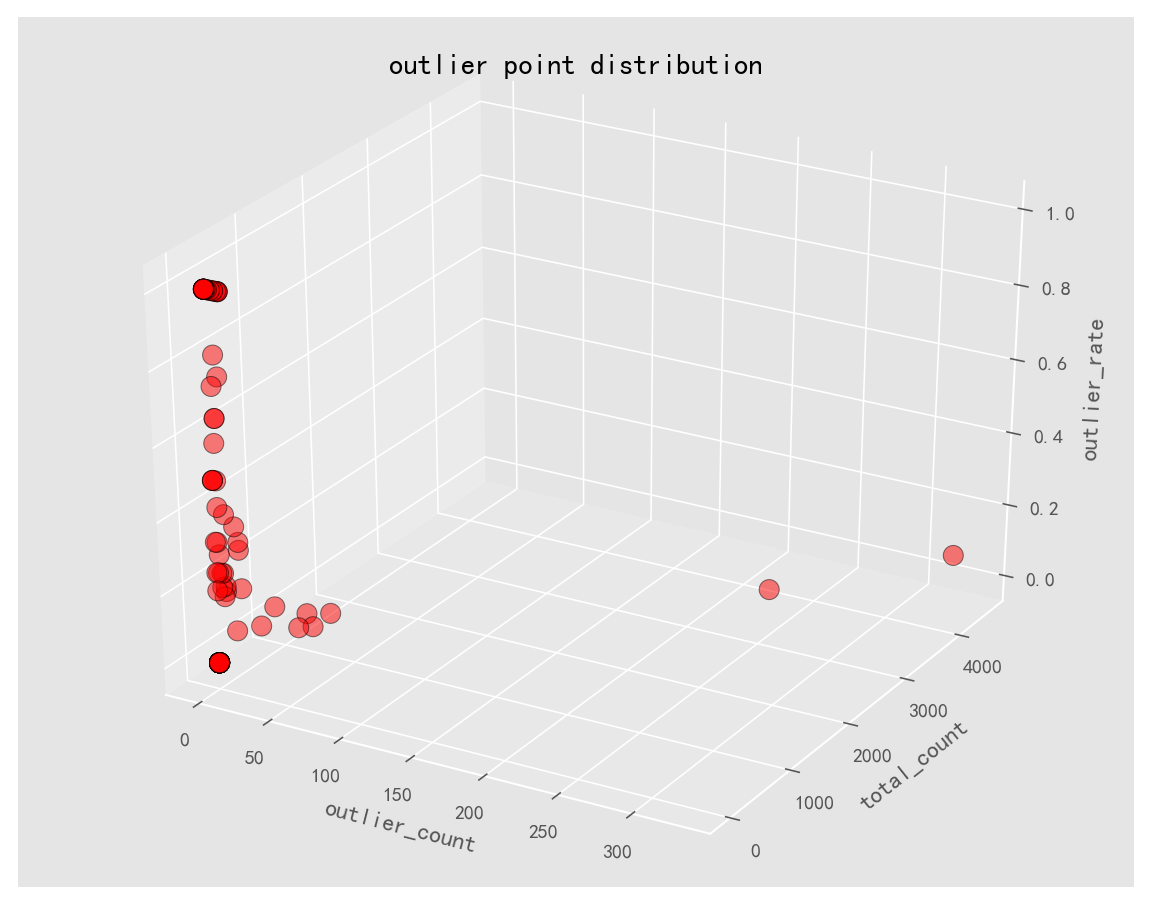

In [56]:
# 异常点图形展示
plt.style.use('ggplot')  # 使用ggplot样式库
fig = plt.figure(figsize=(10, 8))  # 创建画布对象
# 画图
ax = fig.add_subplot(111, projection='3d')
ax.scatter(source_merge['outlier_count'], source_merge['total_count'], source_merge['outlier_rate'],
           s=100, edgecolors='k', c='r', marker='o',alpha=0.5) 
ax.set_xlabel('outlier_count')
ax.set_ylabel('total_count')
ax.set_zlabel('outlier_rate')
plt.title('outlier point distribution')  # 设置图像标题

## 4.6 时间序列分析

### Python调用R实现auto arima

In [57]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

> 读者可执行下面代码，执行使用Python调用R执行

In [58]:
'''
r_file = 'auto_arima.R'
robjects.r.source(r_file)
'''

"\nr_file = 'auto_arima.R'\nrobjects.r.source(r_file)\n"

In [59]:
# 验证库
r_script = '''
    if (!require('forecast'))
      install.packages('forecast')
    if (!require('Metrics'))
      install.packages('Metrics')
'''
robjects.r(r_script)

rpy2.rinterface.NULL

In [60]:
# 导入库
forecast = importr('forecast')
Metrics = importr('Metrics')
stats = importr('stats')

In [61]:
# 读取数据
date_parse = lambda dates: pd.datetime.strptime(dates, '%Y/%m/%d')
raw_data = pd.read_csv('time_series.txt',index_col='Date', date_parser=date_parse)
print(raw_data.head())

            Orders
Date              
2018-01-01     281
2018-01-02     304
2018-01-03     292
2018-01-04     360
2018-01-05     320


In [62]:
# 数据预处理
# 拆分训练集和测试集
train_ts = raw_data.iloc[:100]
test_ts = raw_data.iloc[100:]
# 转换为R对象
ts_data = robjects.FloatVector(raw_data.values)
train_ts = robjects.FloatVector(train_ts.values)
test_ts = robjects.FloatVector(test_ts.values)

In [63]:
# 模型训练
model = forecast.auto_arima(train_ts,ic='aic')
print(model)

Series: c(281, 304, 292, 360, 320, 185, 300, 297, 301, 199, 210, 377,  361, 349, 400, 175, 210, 300, 160, 140, 327, 166, 280, 307, 189,  161, 99, 80, 77, 90, 132, 87, 66, 88, 92, 166, 147, 77, 147,  90, 67, 221, 110, 196, 180, 210, 201, 166, 172, 201, 188, 218,  231, 195, 201, 237, 241, 166, 232, 261, 221, 189, 161, 104, 97,  154, 92, 79, 91, 99, 94, 87, 142, 156, 143, 173, 143, 121, 101,  166, 193, 147, 177, 166, 110, 131, 96, 76, 66, 77, 172, 161,  147, 112, 94, 210, 166, 184, 210, 222) 

ARIMA(2,1,1) 



Coefficients:

          ar1      ar2     ma1

      -0.8648  -0.5009  0.4584

s.e.   0.1608   0.0879  0.1768



sigma^2 estimated as 3024:  log likelihood=-535.93

AIC=1079.86   AICc=1080.29   BIC=1090.24



In [64]:
# 模型校验
in_ts_predict = stats.predict(model,(len(raw_data)-100)) # 预测数据
predict_pred = in_ts_predict.rx2('pred') # 取出预测值
Metrics.rmse(test_ts, predict_pred)

97.830862


In [65]:
# 重新训练模型并预测
model = forecast.auto_arima(ts_data,ic='aic')
print(model)
out_ts_predict = forecast.forecast(model, h=10, level=0.95)

Series: c(281, 304, 292, 360, 320, 185, 300, 297, 301, 199, 210, 377,  361, 349, 400, 175, 210, 300, 160, 140, 327, 166, 280, 307, 189,  161, 99, 80, 77, 90, 132, 87, 66, 88, 92, 166, 147, 77, 147,  90, 67, 221, 110, 196, 180, 210, 201, 166, 172, 201, 188, 218,  231, 195, 201, 237, 241, 166, 232, 261, 221, 189, 161, 104, 97,  154, 92, 79, 91, 99, 94, 87, 142, 156, 143, 173, 143, 121, 101,  166, 193, 147, 177, 166, 110, 131, 96, 76, 66, 77, 172, 161,  147, 112, 94, 210, 166, 184, 210, 222, 226, 306, 187, 167, 147,  121, 110, 107, 90, 101, 116, 90, 141, 92, 153, 172, 119, 108,  100, 99, 116, 96, 60, 71, 112, 121, 113, 140, 92, 191, 99, 110,  167, 90, 90, 161, 196, 206, 301, 199, 181, 144, 171, 96, 66,  47, 150, 141, 201) 

ARIMA(5,1,4) 



Coefficients:

         ar1      ar2     ar3     ar4     ar5      ma1     ma2      ma3

      0.1995  -0.6467  0.5306  0.0288  0.2579  -0.6491  0.6995  -0.7294

s.e.  0.3451   0.1473  0.2421  0.2207  0.0938   0.3505  0.2644   0.2872

          ma4

   

In [66]:
# 获取预测信息
out_ts_pre_pred = np.array(out_ts_predict.rx2('mean')) # 取出预测均值
out_ts_pre_lower = np.array(out_ts_predict.rx2('lower')) # 取出预测下限值
out_ts_pre_upper = np.array(out_ts_predict.rx2('upper')) # 取出预测上限值
predict_plt = pd.DataFrame.from_dict({'mean':out_ts_pre_pred,'lower':[i[0] for i in out_ts_pre_lower],'upper':[i[0] for i in out_ts_pre_upper]})
predict_plt.index = [max(raw_data.index)+datetime.timedelta(days=i+1) for i in range(10)]
print(predict_plt.head())

                  mean      lower       upper
2018-05-30  186.934135  88.830278  285.037991
2018-05-31  140.078937  28.101036  252.056837
2018-06-01  159.580017  36.851422  282.308612
2018-06-02  175.244769  39.240687  311.248852
2018-06-03  155.969476  18.386853  293.552099


Text(0.5,1,'time series predicted data')

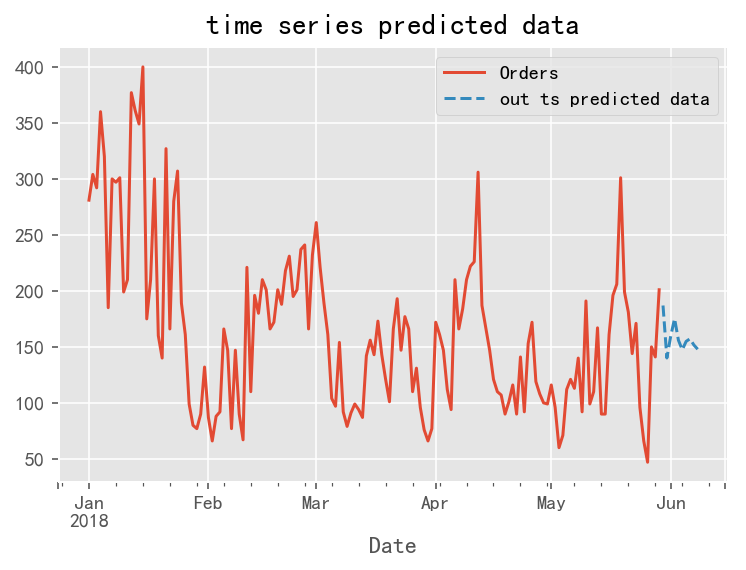

In [67]:
# 显示完整时间序列
raw_data.plot()  # 原始数据展示
predict_plt['mean'].plot(label='out ts predicted data', style='--')  # 预测数据展示
plt.legend(loc='best')  # 设置图例位置
plt.title('time series predicted data')  # 设置标题

## 内容延伸1：非结构化数据的分析与挖掘

### 4.9.1 词频统计

In [68]:
# 导入库
import re  # 正则表达式库
import collections  # 词频统计库
import numpy as np  # numpy库
import jieba  # 结巴分词
import wordcloud  # 词云展示库
from PIL import Image  # 图像处理库
import matplotlib.pyplot as plt  # 图像展示库

In [69]:
# 读取文本文件
with open('article1.txt') as fn:
    string_data = fn.read()  # 使用read方法读取整段文本

In [70]:
# 文本预处理
pattern = re.compile(u'\t|\n|\.|-|一|:|;|\)|\(|\?|"')  # 建立正则表达式匹配模式
string_data = re.sub(pattern, '', string_data)  # 将符合模式的字符串替换掉

In [71]:
# 文本分词
seg_list_exact = jieba.cut(string_data, cut_all=False)  # 精确模式分词[默认模式]
remove_words = ['的', '，', '和', '是', '随着', '对于', ' ', '对', '等', '能', '都', '。', '、', '中', '与', '在', '其', '了', '可以', '进行', '有', '更', '需要', '提供', '多', '能力', '通过', '会', '不同', '一个', '这个', '我们', '将', '并', '同时', '看', '如果', '但', '到', '非常', '—', '如何', '包括', '这']  # 自定义去除词库
# remove_words = [] #空去除词列表，用于跟关键字提取做效果对比
object_list = [i for i in seg_list_exact if i not in remove_words] # 将不在去除词列表中的词添加到列表中

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache D:\system_backup\Temp\jieba.cache
DEBUG:jieba:Loading model from cache D:\system_backup\Temp\jieba.cache
Loading model cost 0.878 seconds.
DEBUG:jieba:Loading model cost 0.878 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


In [72]:
# 词频统计
word_counts = collections.Counter(object_list)  # 对分词做词频统计
word_counts_top5 = word_counts.most_common(5)  # 获取前10个频率最高的词
for w, c in word_counts_top5:  # 分别读出每条词和出现从次数
    print(w, c)  # 打印输出

数据 113
分析 48
功能 47
Adobe 45
Analytics 37


(-0.5, 509.5, 516.5, -0.5)

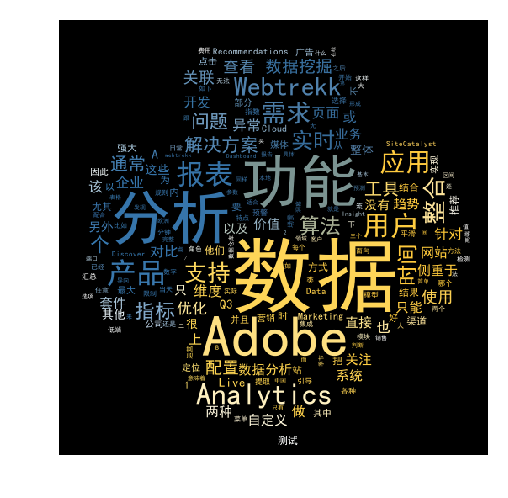

In [73]:
# 词频展示
mask = np.array(Image.open('wordcloud.jpg'))  # 定义词频背景
wc = wordcloud.WordCloud(
    font_path='C:/Windows/Fonts/simhei.ttf',  # 设置字体格式，不设置将无法显示中文
    mask=mask,  # 设置背景图
    max_words=200,  # 设置最大显示的词数
    max_font_size=100  # 设置字体最大值
)
wc.generate_from_frequencies(word_counts)  # 从字典生成词云
image_colors = wordcloud.ImageColorGenerator(mask)  # 从背景图建立颜色方案
wc.recolor(color_func=image_colors)  # 将词云颜色设置为背景图方案
plt.imshow(wc)  # 显示词云
plt.axis('off')  # 关闭坐标轴

### 4.9.2 词性标注

In [74]:
# 导入库
import jieba.posseg as pseg
import pandas as pd

In [75]:
# 读取数据
with open('article1.txt') as fn:
    string_data = fn.read()  # 使用read方法读取整段文本

In [76]:
# 分词+词性标注
words = pseg.cut(string_data)  # 分词
words_pd = pd.DataFrame(words, columns=['word', 'type'])  # 创建结果数据框
print(words_pd.head(4))  # 展示结果前4条

        word type
0      Adobe  eng
1               x
2  Analytics  eng
3          和    c


In [77]:
# 词性分类汇总-两列分类
words_gb = words_pd.groupby(['type', 'word'])['word'].count()
print(words_gb.head(4))

type  word
a     不同      14
      不足       2
      不通       1
      严谨       2
Name: word, dtype: int64


In [78]:
# 词性分类汇总-单列分类
words_gb2 = words_pd.groupby('type').count()
words_gb2 = words_gb2.sort_values(by='word', ascending=False)
print(words_gb2.head(4))

      word
type      
x      994
n      981
v      834
eng    295


In [79]:
# 选择特定类型词语做展示
words_pd_index = words_pd['type'].isin(['n', 'eng'])
words_pd_select = words_pd[words_pd_index]
print(words_pd_select.head(4))

        word type
0      Adobe  eng
2  Analytics  eng
4   Webtrekk  eng
9         领域    n


### 4.9.3 关键字提取

In [80]:
# 导入库
import jieba.analyse  # 导入关键字提取库
import pandas as pd  # 导入pandas
# 读取文本数据
with open('article1.txt') as fn:
    string_data = fn.read()  # 使用read方法读取整段文本
# 关键字提取
tags_pairs = jieba.analyse.extract_tags(string_data, topK=5, withWeight=True, allowPOS=['ns', 'n', 'vn', 'v', 'nr'], withFlag=True)  # 提取关键字标签
tags_list = [(i[0].word, i[0].flag, i[1]) for i in tags_pairs]  #
tags_pd = pd.DataFrame(tags_list, columns=['word', 'flag', 'weight'])  # 创建数据框
print(tags_pd)  # 打印数据框

  word flag    weight
0   数据    n  0.313395
1   报表    n  0.163367
2   功能    n  0.150263
3   分析   vn  0.134857
4   用户    n  0.126633


### 4.9.4 文本聚类

In [81]:
# 导入库
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # 基于TF-IDF的词频转向量库
from sklearn.cluster import KMeans
import jieba.posseg as pseg

In [82]:
# 中文分词
def jieba_cut(comment):
    seg_list = pseg.cut(comment)  # 精确模式分词[默认模式]
    word_list = [i.word for i in seg_list if i.flag in ['a', 'ag', 'an']] # 只选择形容词追加到列表中
    return word_list

In [83]:
# 读取数据文件
with open('comment.txt',encoding='utf8') as fn:
    comment_list = fn.readlines()  # 读取文件内容为列表

In [84]:
# word to vector
stop_words = ['…', '。', '，', '？', '！', '+', ' ', '、', '：', '；', '（', '）', '.', '-']  # 定义停用词
vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=jieba_cut, use_idf=True)  # 创建词向量模型
X = vectorizer.fit_transform(comment_list)  # 将评论关键字列表转换为词向量空间模型

In [85]:
# K均值聚类
model_kmeans = KMeans(n_clusters=3)  # 创建聚类模型对象
model_kmeans.fit(X)  # 训练模型

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [86]:
# 聚类结果汇总
cluster_labels = model_kmeans.labels_  # 聚类标签结果
word_vectors = vectorizer.get_feature_names()  # 词向量
word_values = X.toarray()  # 向量值
comment_matrix = np.hstack(
    (word_values, cluster_labels.reshape(word_values.shape[0], 1)))  # 将向量值和标签值合并为新的矩阵
word_vectors.append('cluster_labels')  # 将新的聚类标签列表追加到词向量后面
comment_pd = pd.DataFrame(comment_matrix, columns=word_vectors)  # 创建包含词向量和聚类标签的数据框
print(comment_pd.head(1))  # 打印输出数据框第1条数据

    一般   不厚   不爽   不贵   不错   不高   便宜   具体   准确    凹       ...          蓝   诚意  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       ...        0.0  0.0   

     贵    足   透亮   重要    难         高   麻烦  cluster_labels  
0  0.0  0.0  0.0  0.0  0.0  0.392535  0.0             1.0  

[1 rows x 64 columns]


In [87]:
# 聚类结果分析
comment_cluster1 = comment_pd[comment_pd['cluster_labels'] == 2].drop('cluster_labels', axis=1)  # 选择聚类标签值为2的数据，并删除最后一列
word_importance = np.sum(comment_cluster1, axis=0)  # 按照词向量做汇总统计
print(word_importance.sort_values(ascending=False)[:5])  # 按汇总统计的值做逆序排序并打印输出前5个词

不错    5.001647
快     2.839514
特高    0.843920
慢     0.780092
一般    0.641269
dtype: float64


## 4.10 内容延伸2：自动化数据挖掘与机器学习

### 4.10.2 使用TPOT做自动化学习

### 1. 使用TPOT做自动分类应用

In [88]:
# 导入库
from tpot import TPOTClassifier  # 导入分类库
from sklearn.datasets import load_iris  # 导入加载iris数据集库
from sklearn.model_selection import train_test_split  # 导入分割数据集库

In [89]:
# 加载数据集并分割
iris = load_iris()  # 加载数据集
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, train_size=0.75, test_size=0.25)  # 将数据集分割为训练集和测试集

In [90]:
# 训练模型并输出结果
tpot = TPOTClassifier(population_size=10, offspring_size=100, scoring='accuracy', cv=3, n_jobs=2, max_time_mins=5, max_eval_time_mins=2, random_state=0, config_dict=None, periodic_checkpoint_folder=None, verbosity=1)  # 建立自动分类训练对象
tpot.fit(X_train, y_train)  # 自动分类训练
print(tpot.predict(X_test)[:3]) # 预测测试集前三条分类
print(tpot.predict_proba(X_test)[:3]) # 预测测试集前三条分类概率
print(tpot.score(X_test, y_test))  # 输出分类模型得分
tpot.export('tpot_iris_pipeline.py')  # 导出自动分类pipeline的代码


5.0094 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: KNeighborsClassifier(CombineDFs(input_matrix, KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), n_neighbors=35, p=1, weights=uniform)), n_neighbors=5, p=2, weights=distance)


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


[1 2 0]


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


0.9473684210526315


True

### 2. 使用TPOT做自动回归应用

In [91]:
# 导入库
from tpot import TPOTRegressor  # 导入回归库
from sklearn.datasets import load_boston  # 加载波士顿房价数据集库
from sklearn.model_selection import train_test_split  # 导入分割数据集库

In [92]:
# 加载数据集并分割
raw_data = load_boston()  # 加载波士顿房价数据集
X_train, X_test, y_train, y_test = train_test_split(raw_data.data, raw_data.target, train_size=0.75, test_size=0.25)  # 将数据集分割为训练集和测试集

In [93]:
# 训练模型并输出结果
tpot = TPOTRegressor(population_size=10, offspring_size=100, scoring='neg_mean_squared_error', cv=3, n_jobs=2, max_time_mins=5,  max_eval_time_mins=2, random_state=0, config_dict=None, periodic_checkpoint_folder=None, verbosity=1)  # 建立自动分类训练对象
tpot.fit(X_train, y_train)  # 自动回归训练
print(tpot.predict(X_test)[:3]) # 预测测试集前三条结果
print(tpot.score(X_test, y_test))  # 输出回归模型得分
tpot.export('tpot_boston_pipeline.py')  # 导出自动回归pipeline的代码


5.133766666666667 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: GradientBoostingRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), alpha=0.99, learning_rate=0.1, loss=huber, max_depth=4, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=9, n_estimators=100, subsample=0.7000000000000001)
[20.13206467 22.57422649 28.1638642 ]
-10.427460424386995


True